Using TensorFlow backend.


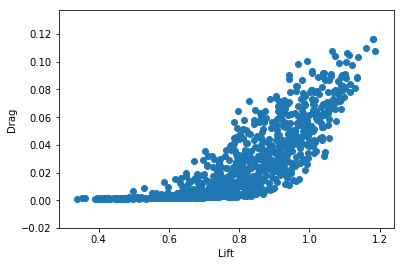

In [1]:
import sys
sys.path.append('../python')
import time
from plot_info import *
from keras.models import Sequential
from keras.layers import Dense, Activation
import keras

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt



import numpy as np

qmc_points = np.loadtxt('../sobol_6_8000.txt')
qmc_points = qmc_points[1:].reshape((8000,6))

all_points = qmc_points.copy()
forces = np.array(np.loadtxt('../force_6_params.dat'))

plt.scatter(forces[:,1], forces[:,2])
plt.xlabel("Lift")
plt.ylabel("Drag")
plt.show()

N = min(qmc_points.shape[0], forces.shape[0])
qmc_points = qmc_points[:N,:]
forces  = forces[:N,:]

permuted_indices = range(N)#np.random.permutation(N)
qmc_points=qmc_points[permuted_indices,:]
forces = forces[permuted_indices,:]
input_size=6
force_component = 1
train_size=128
validation_size=200



In [2]:
def get_network(parameters, data, *,train_size, validation_size, batch_size, title):
    model = Sequential([
        Dense(10, input_shape=(input_size,)),
        Activation('relu'),
        Dense(12),
        Activation('relu'),
        Dense(10),
        Activation('relu'),
        Dense(12),
        Activation('relu'),
        Dense(10),
        Activation('relu'),
        Dense(10),
        Activation('relu'),
        Dense(1)
    ])
    
    
    model.compile(optimizer=keras.optimizers.SGD(lr=0.01),
                  loss='mean_squared_error')
    x_train = parameters[:train_size,:]
    y_train=data[:train_size]
    
    
    x_val = parameters[train_size:validation_size+train_size,:]
    y_val=data[train_size:train_size+validation_size]
    epochs=500000
    
    training_start_time=time.time()
    hist = model.fit(x_train, y_train,batch_size=batch_size, epochs=epochs,shuffle=True, 
                     validation_data=(x_val, y_val),verbose=0)
    training_end_time=time.time()
    print("Training took {} seconds".format (training_end_time-training_start_time))
    
    epochs_r=range(1, epochs)
    plt.loglog(hist.history['loss'])
    plt.title('Training loss (%d samples, batch size: %d)\n%s' %(train_size, batch_size, title))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    showAndSave('training_loss')
    
    plt.loglog(hist.history['val_loss'])
    plt.title('Validation loss (%d samples, batch size: %d)\n%s' %(train_size, batch_size, title))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    showAndSave('validation_loss')
    
    
    
    plt.loglog(hist.history['loss'], label='Training loss')
    plt.loglog(hist.history['val_loss'],label='Validation loss')
    plt.legend()
    plt.title('Training loss and validation loss (%d samples, batch size: %d)\n%s' %(train_size, batch_size, title))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    showAndSave('training_validation_loss')
    
    
    plt.title('Validation loss (%d samples, batch size: %d)\n%s' %(train_size, batch_size, title))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    showAndSave('validation_loss')
    
    
    x_test =  parameters[validation_size+train_size:,:]
    y_test = data[train_size+validation_size:]
    y_predict = model.predict(x_test)
    
    plt.title('Scatter comparision (%d samples, batch size: %d)\n%s' %(train_size, batch_size, title))
    plt.scatter(y_test, y_predict)
    plt.xlabel("Actual data")
    plt.ylabel("Predicted data")
    showAndSave("scatter_comparison")
    print(model.summary())
    
   
    from sklearn import linear_model
    reg = linear_model.LinearRegression()
    coeffs = reg.fit(parameters[:train_size,:], y_train)
    
    evaluated_lsq = coeffs.predict(parameters)
    plt.scatter(data, evaluated_lsq)
    plt.title('Linear Least squares (%d samples)' % (train_size))
    plt.xlabel("Actual data")
    plt.ylabel("Interpolated data")
    showAndSave("scatter_lsq_comparision")
    
    
    def myvar(x):
        mean = np.sum(x)/x.shape[0]
        var = np.sum((mean-x)**2)/x.shape[0]
        return var
        
    def mymean (x): 
        return np.sum(x)/x.shape[0]
    
    variance_top = myvar(data)
    print("variance single level = %f" % variance_top)
    predicted = model.predict(parameters)
    predicted = predicted.reshape(parameters.shape[0])
    variance_diff_ml = myvar(data - predicted)
    
    
    print("variance diff ml = %f " % variance_diff_ml)
    print("speedup = %f" % (variance_top/variance_diff_ml/2.))
    print((data - evaluated_lsq).shape)
    variance_diff_interpolate =myvar(data - evaluated_lsq)
    print("variance_diff_interpolate = %f" % variance_diff_interpolate)
    
    mean_qmc = np.mean(data)
    print("mean_qmc = %f" % mean_qmc)
    mean_ml = np.mean(model.predict(parameters))
    print("mean_ml = %f" % mean_ml)
    mean_few_qmc = np.mean(parameters[:train_size,:])
    
    print("mean_few_qmc = %f" % mean_few_qmc)
    predicted_all = model.predict(all_points)
    predicted_all = predicted_all.reshape(all_points.shape[0])
    print(predicted_all.shape)
    mean_mlmlmc = mymean(predicted[:train_size]-data[:train_size]) + mymean(predicted_all)
    
    print("mean_mlmlmc = %f" % mean_mlmlmc)
    var_qmc = np.var(data)
    print("var_qmc = %f" % var_qmc)
    var_ml = np.var(model.predict(parameters))
    print("var_ml = %f" % var_ml)
    var_few_qmc = np.var(parameters[:train_size,:])
    
    print("var_few_qmc = %f" % var_few_qmc)
    print(parameters.shape)
    
    
   
    plt.hist(data,bins=40,density=True,label='QMC %d samples' % parameters.shape[0],alpha=0.5)
    plt.title("Comparison QMC and DLMC\n%s\nepochs=%d,batch_size=%d"% (title, epochs,batch_size))
    plt.hist(model.predict(parameters),bins=40,density=True,label='DLMC (%d samples)' % train_size,alpha=0.5)
    plt.legend()
    showAndSave('hist_qmc_ml_%s' % title)
    
    
    plt.title("Comparison QMC with %d and QMC with %d samples\n%s" %(parameters.shape[0], train_size, title))
    plt.hist(data,bins=40,density=True,label='QMC %d samples' % parameters.shape[0],alpha=0.5)
    plt.hist(data[:train_size],bins=40,density=True, alpha=0.5,label='QMC %d samples' % train_size)
    plt.legend()
    showAndSave('hist_qmc_qmc_%s' % title)
    
    plt.title("Comparison QMC with least squares\n%s" % title)
    plt.hist(data,bins=40,density=True,label='QMC %d samples' % train_size,alpha=0.5)
    plt.hist(evaluated_lsq,bins=40,density=True,alpha=0.5, label='Least squares (%d points)' % train_size)
    plt.legend()
    showAndSave('hist_qmc_lsq_%s' % title)
    
    
    
    
    plt.hist(data,bins=20,density=True,label='QMC %d samples' % parameters.shape[0],alpha=0.5)
    plt.title("(coarse hist) Comparison QMC and DLMC\n%s\nepochs=%d,batch_size=%d"% (title, epochs,batch_size))
    plt.hist(model.predict(parameters),bins=20,density=True,label='DLMC(%d samples)' % train_size,alpha=0.5)
    plt.legend()
    showAndSave('hist_qmc_ml_coarse_%s' % title)
    
    
    plt.title("(coarse hist) Comparison QMC with %d and QMC with %d samples\n%s" %(parameters.shape[0], train_size, title))
    plt.hist(data,bins=20,density=True,label='QMC %d samples' % parameters.shape[0],alpha=0.5)
    plt.hist(data[:train_size],bins=20,density=True, alpha=0.5,label='QMC %d samples' % train_size)
    plt.legend()
    showAndSave('hist_qmc_qmc_coarse_%s' % title)
    
    plt.title("(coarse hist) Comparison QMC with least squares\n%s" % title)
    plt.hist(data,bins=20,density=True,label='QMC %d samples' % train_size,alpha=0.5)
    plt.hist(evaluated_lsq,bins=20,density=True,alpha=0.5, label='Least squares (%d points)' % train_size)
    plt.legend()
    showAndSave('hist_qmc_lsq_coarse_%s' % title)
    
    samples = range(0,data.shape[0])
    stats = {}
    for stat in ['mean', 'var']:
        stats[stat]={}
        stats[stat]['sources']={}
        if stat == 'mean':
            stats[stat]['compute']=lambda x: sum(x)/x.shape[0]
        else:
            stats[stat]['compute']=lambda x: sum(x**2)/x.shape[0]-(sum(x)/x.shape[0])**2
    
     
        stats[stat]['sources']['QMC']={}
        stats[stat]['sources']['DLMC'] = {}
        stats[stat]['sources']['Least squares'] = {}
        stats[stat]['sources']['DLbMC'] = {}
    
        stats[stat]['sources']['QMC']['data']=array([stats[stat]['compute'](data[:k]) for k in samples])
        stats[stat]['sources']['DLMC']['data'] = array([stats[stat]['compute'](array(model.predict(parameters[:k,:]))) for k in samples])
        stats[stat]['sources']['Least squares']['data'] = array([stats[stat]['compute'](evaluated_lsq[:k]) for k in samples])
        
        stats[stat]['sources']['DLbMC']['data'] = [0]
        
        for k in samples[1:]:
            if stat == 'mean':
                mean = sum(model.predict(parameters[:train_size,:])-data[:train_size])/train_size +\
                sum(model.predict(parameters[:k,:]))/k
                

                stats[stat]['sources']['DLbMC']['data'].append(mean)
            elif stat=='var':
                mean = sum(model.predict(parameters[:train_size,:])-data[:train_size])/train_size +\
                sum(model.predict(parameters[:k,:]))/k
                
                m2 = sum((model.predict(parameters[:train_size,:]))**2-(data[:train_size])**2)/train_size +\
                sum(model.predict(parameters[:k,:])**2)/k
                

                stats[stat]['sources']['DLbMC']['data'].append(m2-mean**2)
                
        stats[stat]['sources']['DLbMC']['data']=array(stats[stat]['sources']['DLbMC']['data'])
        
        sources = stats[stat]['sources'].keys()
        for source in sources:
            
            stats[stat]['sources'][source]['representative'] = stats[stat]['sources'][source]['data'][-1]
            
        
       
    
        for source in stats[stat]['sources'].keys():
            if 'DLbMC' not in source:
                plt.plot(samples, stats[stat]['sources'][source]['data'], label=source)
        plt.xlabel('Number of samples ($J_N$)')
        plt.ylabel('%s' % stat)
        plt.title('%s as a function of number of samples used for evaluation\n%s' % (stat, title))
        plt.legend()
        showAndSave('function_of_samples_airfoil_%s_%s'  % (stat, title))
        stats[stat]['sources']['QMC_%d' % train_size] = {}
        stats[stat]['sources']['QMC_%d' % train_size]['representative'] = stats[stat]['sources']['QMC']['data'][train_size]
    sources = [source for source in stats['mean']['sources'].keys()]
    for source in sources:
        if source != sources[-1]:
            sys.stdout.write('\\multicolumn{2}{c|}{\\textbf{%s}} &&' % source)
        else:
            sys.stdout.write('\\multicolumn{2}{c|}{\\textbf{%s}} \\\\ \n' % source)
    for source in sources:
        for stat in ['mean', 'var']:
            if not (stat == 'var' and source ==  sources[-1]):
                sys.stdout.write("%s && " % stat)
            else:
                sys.stdout.write("%s \\\\ " % stat)
           
    for source in sources:
        for stat in ['mean', 'var']:
            if not (stat == 'var' and source ==  sources[-1]):
                sys.stdout.write("%.5f &&" % stats[stat]['sources'][source]['representative'])
            else:
                sys.stdout.write("%.5f \\\\ \n" % stats[stat]['sources'][source]['representative'])
            
        
    #for stat in ['mean', 'var']:
    #    stats[stat]={}
    #    stats[stat]['sources']={}
    #    if stat == 'mean':
    #        stats[stat]['compute']=lambda x: sum(x)/x.shape[0]
    #    else:
    #        stats[stat]['compute']=lambda x: sum(x**2)/x.shape[0]-(sum(x)/x.shape[0])**2
    #
    # 
    #    stats[stat]['sources']['QMC']={}
    #    stats[stat]['sources']['DLMC'] = {}
    #    stats[stat]['sources']['Least squares'] = {}
    #
    #    stats[stat]['sources']['QMC']['data']=array([stats[stat]['compute'](data[:k]) for k in samples])
    #    stats[stat]['sources']['DLMC']['data'] = array([stats[stat]['compute'](array(model.predict(parameters[:k,:]))) for k in samples])
    #    stats[stat]['sources']['Least squares']['data'] = array([stats[stat]['compute'](evaluated_lsq[:k]) for k in samples])
    #    stats[stat]['sources']['DLbMC']['data'] = []
    #    
    #    
    #   
    #
    #    for source in stats[stat]['sources'].keys():
    #        plt.plot(samples, stats[stat]['sources'][source]['data'], label=source)
    #        plt.xlabel('Number of samples ($J_N$)')
    #        plt.ylabel('%s' % stat)
    #        plt.title('%s as a function of number of samples used for evaluation\n%s\n%s' % (stat, title,source))
    #        plt.legend()
    #        showAndSave('function_of_samples_airfoil_%s_%s_%s' % (source, stat, title))
    #
    #
    #for stat in ['mean','var']:
        
        
        
    return model

# One network per variable

In [ ]:
force_names=['Lift', 'Drag']
batch_sizes=[16, 32, train_size]

for batch_size in batch_sizes:
    for (n, f) in enumerate(force_names):
        showAndSave.prefix='airfoil_%s_ts_%d_bs_%d' %(f,batch_size, train_size)
        network= get_network(qmc_points, forces[:,n+1], train_size=train_size, validation_size=validation_size,
                        batch_size=batch_size, title=f)
    
    



# One network to rule them all

In [ ]:
def get_network_dual(parameters, data, *,train_size, validation_size, batch_size, title, names):
    model = Sequential([
        Dense(10, input_shape=(input_size,)),
        Activation('relu'),
        Dense(12),
        Activation('relu'),
        Dense(10),
        Activation('relu'),
        Dense(12),
        Activation('relu'),
        Dense(10),
        Activation('relu'),
        Dense(10),
        Activation('relu'),
        Dense(data.shape[1])
    ])
    
    
    model.compile(optimizer=keras.optimizers.SGD(lr=0.01),
                  loss='mean_squared_error')
    x_train = parameters[:train_size,:]
    y_train=data[:train_size,:]
    
    
    x_val = parameters[train_size:validation_size+train_size,:]
    y_val=data[train_size:train_size+validation_size,:]
    epochs=500000
    
    training_start_time=time.time()
    hist = model.fit(x_train, y_train,batch_size=batch_size, epochs=epochs,shuffle=True, 
                     validation_data=(x_val, y_val),verbose=0)
    training_end_time=time.time()
    print("Training took {} seconds".format (training_end_time-training_start_time))
    
    epochs_r=range(1, epochs)
    plt.loglog(hist.history['loss'])
    plt.title('Training loss (%d samples, batch size: %d, output_size: %d)\n%s' %(train_size, batch_size, data.shape[1], title))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    showAndSave('training_loss_dual')
    
    plt.loglog(hist.history['val_loss'])
    plt.title('Validation loss (%d samples, batch size: %d, output_size: %d)\n%s' %(train_size, batch_size, data.shape[1], title))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    showAndSave('validation_loss_dual')
    
    
    x_test =  parameters[validation_size+train_size:,:]
    y_test = data[train_size+validation_size:,:]
    y_predict = model.predict(x_test)
    
    for c in range(data.shape[1]):
        plt.title('Scatter comparision %s (%d samples, batch size: %d)\n%s' %(names[c], train_size, batch_size, title))
        plt.scatter(y_test[:,c], y_predict[:,c])
        plt.xlabel("Actual data")
        plt.ylabel("Predicted data")
        showAndSave("scatter_comparison_dual_%s" % names[c])
        print(model.summary())
    
   
    from sklearn import linear_model
    
      
    for c in range(data.shape[1]):
        reg = linear_model.LinearRegression()
        coeffs = reg.fit(parameters[:train_size,:], y_train[:,c])
        evaluated_lsq = coeffs.predict(parameters)
        plt.scatter(data[:,c], evaluated_lsq)
        plt.title('Linear Least squares %s (%d samples)' % (names[c], train_size))
        plt.xlabel("Actual data")
        plt.ylabel("Interpolated data")
        showAndSave("scatter_lsq_comparision_dual_%s" % names[c])
    
   
 
        plt.hist(data[:,c],bins=40,density=True,label='QMC %d samples' % parameters.shape[0],alpha=0.5)
        plt.title("Comparison QMC and DLMC %s\n%s\nepochs=%d, batch_size=%d"% (names[c], title, epochs,batch_size))
        plt.hist(model.predict(parameters)[:,c],bins=40,density=True,label='DLMC(%d samples)' % train_size,alpha=0.5)
        plt.legend()
        showAndSave('hist_qmc_ml_dual_%s' % names[c])
        
        
        plt.title("Comparison QMC with %d and QMC with %d samples\n%s\n%s" %(parameters.shape[0], train_size, names[c], title))
        plt.hist(data[:,c],bins=40,density=True,label='QMC %d samples' % parameters.shape[0],alpha=0.5)
        plt.hist(data[:train_size,c],bins=40,density=True, alpha=0.5,label='QMC %d samples' % train_size)
        plt.legend()
        showAndSave('hist_qmc_qmc_dual_%s' % names[c])
        
        plt.title("Comparison QMC with least squares %s\n%s" % (names[c], title))
        plt.hist(data[:,c],bins=40,density=True,label='QMC %d samples' % train_size,alpha=0.5)
        plt.hist(evaluated_lsq,bins=40,density=True,alpha=0.5, label='Least squares (%d points)' % train_size)
        plt.legend()
        showAndSave('hist_qmc_lsq_dual_%s' % names[c])
        
        
        
        
        
        plt.hist(data[:,c],bins=20,density=True,label='QMC %d samples' % parameters.shape[0],alpha=0.5)
        plt.title("Comparison QMC and DLMC %s\n%s\nepochs=%d, batch_size=%d"% (names[c], title, epochs,batch_size))
        plt.hist(model.predict(parameters)[:,c],bins=20,density=True,label='DLMC(%d samples)' % train_size,alpha=0.5)
        plt.legend()
        showAndSave('hist_qmc_ml_dual_%s_coarse' % names[c])
        
        
        plt.title("Comparison QMC with %d and QMC with %d samples\n%s\n%s" %(parameters.shape[0], train_size, names[c], title))
        plt.hist(data[:,c],bins=20,density=True,label='QMC %d samples' % parameters.shape[0],alpha=0.5)
        plt.hist(data[:train_size,c],bins=20,density=True, alpha=0.5,label='QMC %d samples' % train_size)
        plt.legend()
        showAndSave('hist_qmc_qmc_dual_%s_coarse' % names[c])
        
        plt.title("Comparison QMC with least squares %s\n%s" % (names[c], title))
        plt.hist(data[:,c],bins=20,density=True,label='QMC %d samples' % train_size,alpha=0.5)
        plt.hist(evaluated_lsq,bins=20,density=True,alpha=0.5, label='Least squares (%d points)' % train_size)
        plt.legend()
        showAndSave('hist_qmc_lsq_dual_%s_coarse' % names[c])
        
        
        
        
        samples = range(0,data.shape[0])
        stats = {}
        for stat in ['mean', 'var']:
            stats[stat]={}

            stats[stat]['sources']={}
            if stat == 'mean':
                stats[stat]['compute']=lambda x: sum(x)/x.shape[0]
            else:
                stats[stat]['compute']=lambda x: sum(x**2)/x.shape[0]-(sum(x)/x.shape[0])**2
            
            stats[stat]['sources']['QMC']={}
            stats[stat]['sources']['ML'] = {}
            stats[stat]['sources']['Least squares'] = {}
    
            print(parameters.shape)
            print(array(model.predict(parameters[:10,:])).shape)
            print(array(model.predict(parameters[:1,:])).shape)
            print(array(model.predict(parameters[:0,:])).shape)
            stats[stat]['sources']['QMC']['data']=array([stats[stat]['compute'](data[:k,c]) for k in samples])
            
            stats[stat]['sources']['ML']['data'] = [0]
            for k in samples[1:]:
                stats[stat]['sources']['ML']['data'].append(stats[stat]['compute'](array(model.predict(parameters[:k,:]))[:,c]))
                
          
            stats[stat]['sources']['Least squares']['data'] = array([stats[stat]['compute'](evaluated_lsq[:k]) for k in samples])
            
            
            for source in stats[stat]['sources'].keys():
                plt.plot(samples, stats[stat]['sources'][source]['data'], label=source)
            plt.xlabel('Number of samples ($J_N$)')
            plt.ylabel('%s' % stat)
            plt.title('%s as a function of number of samples used for evaluation' % stat)
            showAndSave('function_of_samples_airfoil_dual_%s_%s' % (names[c], stat))
        
    
    return network




In [ ]:
force_names=['Lift', 'Drag']
batch_sizes=[16, 32, train_size]

for batch_size in batch_sizes:
    
    showAndSave.prefix='airfoil_ts_%d_bs_%d_dual' %(batch_size, train_size)
    network= get_network_dual(qmc_points, forces[:,1:], train_size=train_size, validation_size=validation_size,
                        batch_size=batch_size, title="One network for both variables",names=force_names)
    
    

